In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
plt.style.use('classic')

In [6]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [7]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [8]:
def intra_cluster_weighted_similarity(vectors):
    weighted = 0.
    n = 0.
    for k, values in vectors.items():
        n += len(values)
            
    for k, values in vectors.items():
        if len(values) > 0:
            weighted += len(values) * intra_cluster_similarity(values)

    return weighted / n

In [9]:
def inter_cluster_overall_similarity2(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            centroid1 = matx.sum(axis=0) / len(values)
            similarities = []
            for k2, values2 in vectors.items():
                if len(values2) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    centroid2 = matx2.sum(axis=0) / len(values2)
                    similarities.append(cosine_similarity(centroid1, centroid2))
            similarity_topics[k] = np.sum(similarities) / len(similarities)
            
    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [10]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [11]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [12]:
def purity_score(labels_true):
    nh = np.bincount(labels_true)

    return nh[np.argmax(nh)] / sum(nh)

In [13]:
def entropy_score(labels_true):
    entropy = 0.
    cats = np.unique(labels_true)
    ci = len(cats)
    if ci == 1: # math.log(1,2) == 0.0, causes div by zero when normalizing
        ci += 1
    nh = np.bincount(labels_true)
    n = len(labels_true)
    
    for j in cats:
        p_category = nh[j] / n
        entropy += p_category * math.log(p_category, 2)
    
    return -((1 / math.log(ci, 2)) * entropy)

In [14]:
def entropy_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            entropy += (ni / n) * entropy_score(labels_true_topic)
        except:
            entropy += 0.
    return entropy

In [15]:
def purity_weighted_score(labels_size, labels_true):
    purity = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            purity += (ni / n) * purity_score(labels_true_topic)
        except:
            purity += 0.
    return purity

In [16]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [17]:
def text_preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [18]:
import re

#compile regular expressions that match repeated characters and emoji unicode
emoji = re.compile(u'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]',re.UNICODE)
multiple = re.compile(r"(.)\1{1,}", re.DOTALL)

def text_format(text):

    #strip emoji
    stripped = emoji.sub('',text)

    #strip URLs
    stripped = re.sub(r'http[s]?[^\s]+','', stripped)

    #strip html '&amp;', '&lt;', etc.  
    stripped = re.sub(r'[\&].*;','',stripped)

    #strip punctuation
    stripped = re.sub(r'[#|\!|\-|\+|:|//]', " ", stripped)

    #strip whitespace down to one.
    stripped = re.sub('[\s]+' ,' ', stripped).strip()

    #strip multiple occurrences of letters
    stripped = multiple.sub(r"\1\1", stripped)

    #strip all non-latin characters
    stripped = re.sub('[^a-zA-Z0-9|\']', " ", stripped).strip()

    return stripped

In [28]:
from gensim import matutils
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from nltk.tag import pos_tag

print("Building vocabulary...")

docs = {}
doc_tokens = {}
count = 0

for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            text = text_format(text)
            tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
            words = [word for word,pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
            docs[doc['id']]["text"] = " ".join(words)
            clear_output(wait=True)
            count += 1
            print(count)

9095


In [19]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['keyword', 'apiUrl', 'tfidf', 'top_tfidf', 'authors', 'sectionId', 'body', 'id', 'webUrl', 'text', 'tags', 'mod_topic', 'webPublicationDate', 'webTitle', 'section_id', 'guardianId'])

In [20]:
sorted_docs = sorted(docs.items(), key=lambda x: x[0], reverse=True)

In [27]:
token_keys = [x[0] for x in sorted_docs]
token_values = [x[1]["text"] for x in sorted_docs]
print(len(token_values))

9095


In [22]:
token_keys[0]

'2016-05-30-99'

In [23]:
section_id = {}
count = 0
for k, v in docs.items():
    try:
        section_id[v['sectionId']]
    except:
        count += 1
        section_id[v['sectionId']] = count
        
len(section_id.values())

84

# TF-IDF Vectorizer

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9095, 69281)


In [22]:
pickle.dump(X_tfidf, open('tmp/X_tfidf.pickle', 'wb'))

In [21]:
X_tfidf = pickle.load(open('tmp/X_tfidf.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 69281)


# Add Keywords to docs

In [61]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [62]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [63]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['top_tfidf'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['top_tfidf'])

       feature     tfidf
0         bull  0.367068
1         citi  0.332301
2       soccer  0.289241
3           fc  0.209085
4         team  0.207811
5           ml  0.203020
6          fan  0.192072
7         york  0.179047
8      stadium  0.176389
9        derbi  0.165884
10      jersey  0.162874
11         esc  0.161058
12        club  0.151384
13     rivalri  0.141493
14       yanke  0.131158
15     support  0.121895
16       giant  0.117103
17      hudson  0.115708
18    ferrezza  0.112200
19       river  0.105877
20         nyc  0.099118
21        rail  0.095774
22       sport  0.086328
23      yorker  0.075947
24       metro  0.073635
25   manhattan  0.070209
26        tide  0.067413
27     borough  0.065498
28    franchis  0.062221
29       villa  0.059946
30       pride  0.058486
31       group  0.057858
32   hungerusa  0.056100
33      emmitt  0.056100
34     yorknew  0.056100
35     transit  0.054849
36       jeter  0.053686
37  sportscast  0.053686
38     tailgat  0.051973


# Add Vector to docs

In [47]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 196 stored elements in Compressed Sparse Row format>

# Add Section ID to docs

In [73]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

# Add Keyword

In [115]:
for k, v in docs.items():
    docs[k]['tags'] = []
    for keyword in v['keyword']:
        docs[k]['tags'].append(keyword['webTitle'])

docs['2016-05-20-28']['tags']

['MLS',
 'New York Red Bulls',
 'New York City FC',
 'US sports',
 'Football',
 'Sport']

In [116]:
def docs_to_tag_data(docs):
    d = []
    for key, vs in docs.items():
        h = {}
        for v in vs:
            h[v] = True
        d.append(h)

    return(d)

In [117]:
tag_values = docs_to_tag_data(docs)

# Save & Load Docs

In [69]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [53]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['webUrl', 'webTitle', 'body', 'sectionId', 'guardianId', 'text', 'id', 'lda', 'tags', 'apiUrl', 'tfidf', 'authors', 'mod_topic', 'keyword', 'webPublicationDate', 'section_id', 'top_tfidf', 'lda_value', 'lda_vector'])

# Apply Modularity

In [27]:
sub_g = ig.Graph.Read_GML('tmp/sg_02.gml')

In [28]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [29]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
communities = sg.community_multilevel(weights='weight',return_levels=True)
for com in communities:
    print(max(com.membership) + 1)
community = communities[-1]
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))
# community = sg.community_infomap(edge_weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

586
166
140
139
Nodes 8213
Edges 132243
LCC 7950
NO of Communities 139
Modularity 0.7987487477056004


# Reduced Data

In [30]:
reduced_docs = {}
for v in sg.vs():
    reduced_docs[v['name']] = docs[v['name']]

In [31]:
sorted_reduced_docs = sorted(reduced_docs.items(), key=lambda x: x[0], reverse=True)

In [32]:
reduced_tfidf_values = [x[1]['tfidf'] for x in sorted_reduced_docs]

In [33]:
reduced_X_tfidf = scipy.sparse.vstack((reduced_tfidf_values))
reduced_X_tfidf

<8213x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 1089809 stored elements in Compressed Sparse Row format>

In [34]:
reduced_token_keys = [x[0] for x in sorted_reduced_docs]
reduced_token_values = [x[1]["text"] for x in sorted_reduced_docs]
print(len(reduced_token_values))

8213


# LDA

In [24]:
def lda_to_topics(lda_items, threshold):
    topics = {}

    for item in lda_items:
        topic_no = item[1]['lda']
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []

        if item[1]['lda_value'] >= threshold:
            topics[topic_no].append(item[0])

    lda_topics = {}
    lda_keys = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        if len(value) > 0:
            lda_topics[count] = value
            lda_keys[count] = key
        count += 1
        
    return lda_topics, lda_keys

In [25]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaVowpalWabbit

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(reduced_token_values)
vocab = vectorizer.get_feature_names()

print(X_count.shape)

Processing Count
(8213, 63274)


In [39]:
pickle.dump(X_count, open('tmp/X_count_R.pickle', 'wb'))

In [40]:
pickle.dump(vocab, open('tmp/X_count_vocab_R.pickle', 'wb'))

In [24]:
X_count = pickle.load(open('tmp/X_count.pickle', 'rb'))

print(X_count.shape)

(9095, 69281)


In [68]:
def data_to_folds(data, k):
  folds = []

  for i in range(k):
    fold = []
    for j in range(i, data.shape[0], k):
      fold.append(data[j])
    folds.append(np.random.permutation(fold))

  return folds

folds = data_to_folds(X_count, 10)

In [69]:
# Partition data to train and test sets
# return list train data, list of test data
def split_folds(folds, i):
  train = folds[:i] + folds[i+1:]
  train = [x for data in train for x in data] # Flatten
  train = scipy.sparse.vstack((train))
  test = scipy.sparse.vstack(folds[i])
  
  return train, test

In [224]:
X_count_train, X_count_test = split_folds(folds, 9)

In [237]:
num_topics = 10

In [238]:
lda_model = LdaVowpalWabbit('/usr/local/Cellar/vowpal-wabbit/8.1.1/bin/vw',
                     corpus=matutils.Sparse2Corpus(X_count_train.T),
                     num_topics=num_topics,
                     alpha=(1/num_topics),
                     eta=(1/num_topics),
                     passes=50,
                     id2word=dict([(i, s) for i, s in enumerate(vocab)]))

# alpha=0.1 eta=0.01 http://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf

In [239]:
train_log_prep_gensim = lda_model.log_perplexity(matutils.Sparse2Corpus(X_count_train.T))
test_log_prep_gensim = lda_model.log_perplexity(matutils.Sparse2Corpus(X_count_test.T))
print(train_log_prep_gensim)
print(test_log_prep_gensim)
print(np.exp(-train_log_prep_gensim))
print(np.exp(-test_log_prep_gensim))

-8.258062
-8.605109
3858.60886565
5459.48094936


In [116]:
lda_model.save('tmp/gvw_lda_' + str(num_topics) + '_100_k_k')

In [96]:
lda_model = LdaVowpalWabbit.load('tmp/gensim_lda_' + str(num_topics) + '_100_k_k')

In [40]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

8213


In [41]:
for i, mat in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    max_prob = max(mat, key=lambda x: x[1])
    reduced_docs[reduced_token_keys[i]]['lda'] = max_prob[0]
    reduced_docs[reduced_token_keys[i]]['lda_value'] = max_prob[1]
    reduced_docs[reduced_token_keys[i]]['lda_vector'] = mat

0.9998782418117619


In [120]:
pickle.dump(reduced_docs, open('tmp/docs_lda_' + str(num_topics) + '_100.pickle', 'wb'))

In [95]:
reduced_docs = pickle.load(open('tmp/docs_lda_' + str(num_topics) + '_100_k_k.pickle', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/docs_lda_139_100_k_k.pickle'

In [49]:
lda_items = sorted(reduced_docs.items(), key=lambda x: x[1]['lda'])
lda_topics, lda_keys = lda_to_topics(lda_items, 0.0)

In [50]:
len(lda_items)

8213

In [114]:
def lda_to_size_chart(lda_topics):
    print(len(lda_topics.keys()))

    x_data = []
    y_data = []
    for key, value in lda_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(40,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data)
    plt.title("Topic Document Distribution - LDA")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    plt.tight_layout()
    fig.savefig('tmp/size_chart_lda.png')
    plt.show()

75


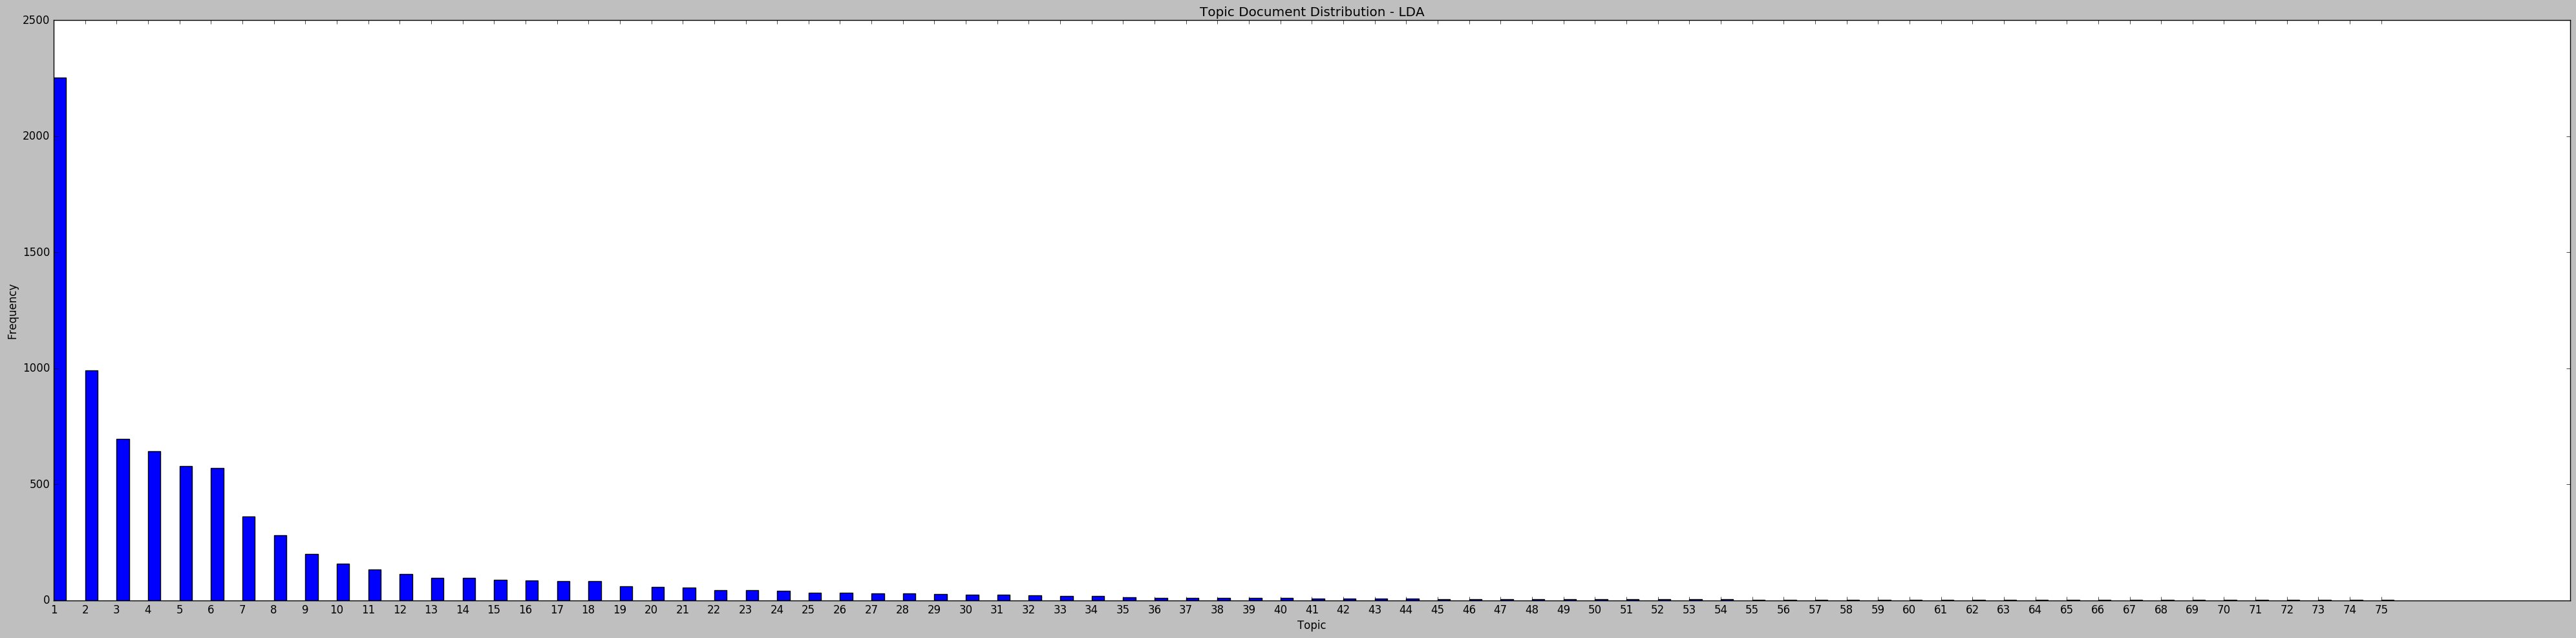

In [56]:
lda_to_size_chart({k: v for k, v in lda_topics.items()})

In [52]:
lda_tfidf_topics = {}

for k, vs in lda_topics.items():
    lda_tfidf_topics[k] = []
    for v in vs:
        lda_tfidf_topics[k].append(reduced_docs[v]['tfidf'])

In [53]:
lda_labels_true = {}

for k, vs in lda_topics.items():
    lda_labels_true[k] = []
    for v in vs:
        lda_labels_true[k].append(reduced_docs[v]['section_id'])

In [54]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(lda_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(lda_tfidf_topics)))

Overall Similarity 0.424
Inter Cluster 0.078
Purity 0.348
Entropy 0.661


In [114]:
print("Intra")
for i in np.arange(10,140,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,140,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")

Intra
0.065,0.114,0.127,0.170,0.197,0.257,0.335,0.403,0.403,0.403,0.403,0.403,0.403,
Inter
0.453,0.296,0.233,0.178,0.145,0.119,0.098,0.085,0.085,0.085,0.085,0.085,0.085,
Purity
0.278,0.320,0.329,0.334,0.336,0.337,0.338,0.339,0.339,0.339,0.339,0.339,0.339,
Entropy
0.676,0.657,0.658,0.657,0.659,0.659,0.658,0.657,0.657,0.657,0.657,0.657,0.657,

# LDA Topic Words

In [99]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaVowpalWabbit
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)
vocab = vectorizer.get_feature_names()

print(X_count.shape)

In [102]:
X_count = pickle.load(open('tmp/X_count.pickle', 'rb'))

print(X_count.shape)

(9095, 69281)


In [103]:
vocab = pickle.load(open('tmp/vocab.pickle', 'rb'))
len(vocab)

69281

In [104]:
num_topics = 139

In [105]:
lda_model = LdaVowpalWabbit('/usr/local/Cellar/vowpal-wabbit/8.1.1/bin/vw',
                     corpus=matutils.Sparse2Corpus(X_count.T),
                     num_topics=num_topics,
                     alpha=(1/num_topics),
                     eta=(1/num_topics),
                     passes=100,
                     id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [106]:
lda_model.save('tmp/gensim_lda_' + str(num_topics) + '_100_k_k_s_full')

## Load LDA

In [48]:
lda_model = LdaVowpalWabbit.load('tmp/gensim_lda_40_100_k_k')

In [107]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9095


In [109]:
for i, mat in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    max_prob = max(mat, key=lambda x: x[1])
    docs[token_keys[i]]['lda'] = max_prob[0]
    docs[token_keys[i]]['lda_value'] = max_prob[1]
    docs[token_keys[i]]['lda_vector'] = mat

0.999890049477735


In [110]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])

In [308]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['lda'], item[0], item[1]['webTitle']))

# LDA Size Chart

In [111]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])
lda_topics, lda_keys = lda_to_topics(lda_items, 0.0)

In [112]:
for key, value in lda_topics.items():
    for v in value:
        docs[v]['lda_topic'] = key
docs['2016-05-20-284'].keys()

dict_keys(['guardianId', 'webUrl', 'lda_topic', 'sectionId', 'tags', 'mod_topic', 'section_id', 'webPublicationDate', 'body', 'lda_value', 'text', 'apiUrl', 'tfidf', 'lda_vector', 'keyword', 'id', 'top_tfidf', 'lda', 'authors', 'webTitle'])

80


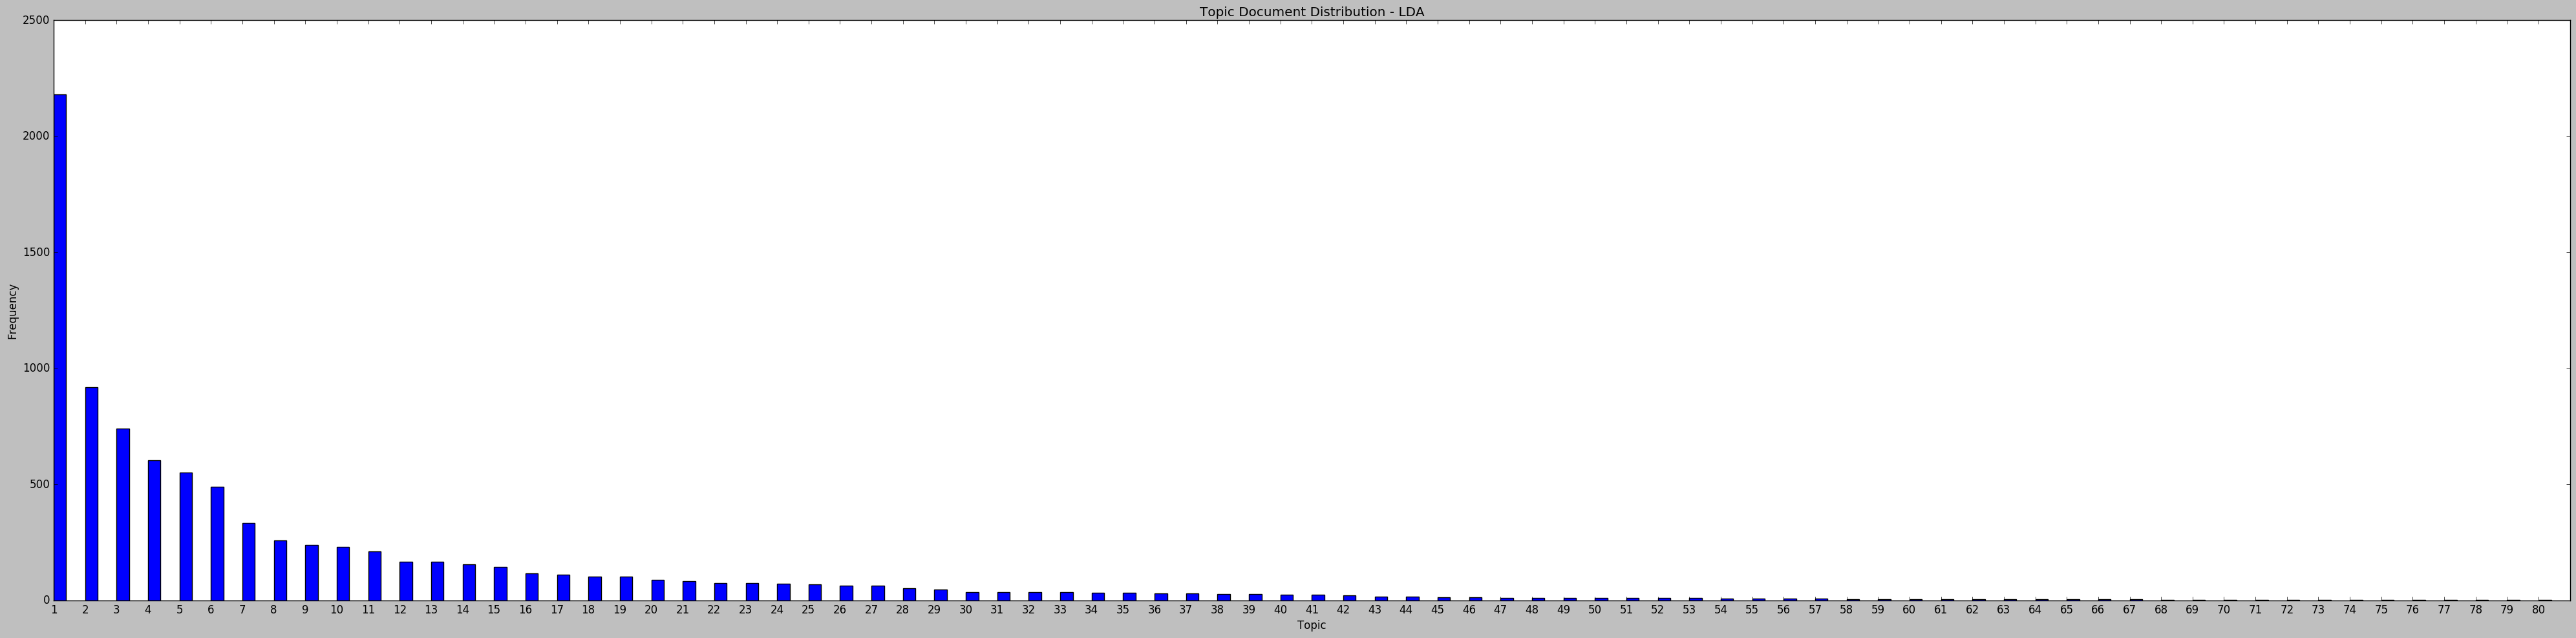

In [115]:
lda_to_size_chart({k: v for k, v in lda_topics.items()})

In [116]:
topics_to_prob_dist(lda_topics)

NameError: name 'topics_to_prob_dist' is not defined

In [117]:
lda_tfidf_topics = {}

for k, vs in lda_topics.items():
    lda_tfidf_topics[k] = []
    for v in vs:
        lda_tfidf_topics[k].append(docs[v]['tfidf'])

In [118]:
lda_labels_true = {}

for k, vs in lda_topics.items():
    lda_labels_true[k] = []
    for v in vs:
        lda_labels_true[k].append(docs[v]['section_id'])

In [119]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(lda_tfidf_topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(lda_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(lda_tfidf_topics)))

Overall Similarity 0.219
Weighted Similarity 0.029
Inter Cluster 0.307


In [207]:
print("Intra")
for i in np.arange(10,51,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,51,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")

Intra
0.044,0.069,0.095,0.109,0.134,
Inter
0.583,0.428,0.348,0.298,0.247,
Purity
0.228,0.277,0.298,0.302,0.304,
Entropy
0.738,0.713,0.705,0.708,0.710,

In [122]:
sub_topics = {k: v for k, v in lda_tfidf_topics.items() if k <= 101}
topic_centroids = cluster_centroids(sub_topics)
matx_c = scipy.sparse.vstack((topic_centroids.values()))
matx_c_c = cosine_similarity(matx_c)
matx_c_c.shape

(16, 16)

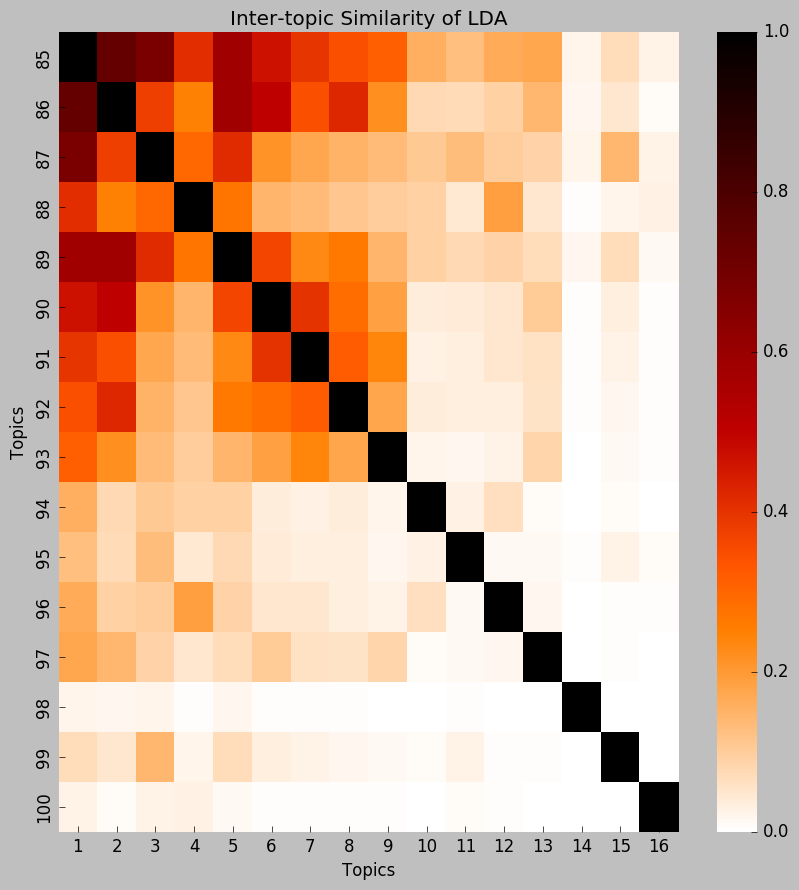

In [123]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(matx_c_c, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,101), yticklabels=(-np.sort(-np.arange(1,101))))
# sns_plt.invert_yaxis()
plt.title("Inter-topic Similarity of LDA")
plt.xlabel("Topics")
plt.ylabel("Topics")

# Keywords

In [120]:
import itertools
from collections import Counter

def keywords_to_keyword_table(topics, n):
    result = {}
    for topic in topics:
        keywords = []
        for top in topic[1]:
            keywords += list(top['feature'])
        net_keywords = Counter(keywords)
        net_keywords = sorted(net_keywords.items(), key=lambda x: x[1], reverse=True)
        keywords2 = list(map(lambda x: x[0], net_keywords))
        result[topic[0]] = (len(topic[1]), keywords2[:n])
    return result

In [121]:
def topics_to_keywords(topics):
    results = {}

    for k, vs in topics.items():
        results[k] = []
        for v in vs:
            top_df = docs[v]['top_tfidf']
#             results[k].append(top_df[(top_df.tfidf >= 0.01)])
            results[k].append(top_df[(top_df.tfidf >= 0.02)])

    results = sorted(results.items(), key=lambda x: len(x[1]), reverse=True)
    
    return results

In [122]:
topics_matrix = lda_model.show_topics(formatted=False, num_words=10, num_topics=lda_model.num_topics)
lda_topic_keywords = {}
count = 1
for topic in topics_matrix:
    lda_topic_keywords[count] = [str(word[1]) for word in topic]
    count += 1

lda_topic_keywords.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [123]:
lda_keywords = {}
for k, v in sorted(lda_topics.items(), key=lambda x: len(x[1]), reverse=True):
    lda_keywords[k] = (len(v), lda_topic_keywords[k])

In [71]:
net_keywords = keywords_to_keyword_table(topics_to_keywords(net_topics), 10)

NameError: name 'net_topics' is not defined

In [102]:
lda_tags = topics_to_tags(lda_topics, 20)
net_tags = topics_to_tags(net_topics, 20)

NameError: name 'topics_to_tags' is not defined

In [124]:
import csv

lda_s_k = sorted(lda_keywords.items(), key=lambda x: x[1][0], reverse=True)
# net_s_k = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)
# lda_s_t = sorted(lda_tags.items(), key=lambda x: x[1][0], reverse=True)
# net_s_t = sorted(net_tags.items(), key=lambda x: x[1][0], reverse=True)


length = len(lda_s_k)
rows = []
for i in range(length):
    row = [i+1]
#     row += [ori_s_t[i][1][0], ori_s_t[i][1][1]]
#     row += [net_s_k[i][1][0], net_s_k[i][1][1]]
    row += [lda_s_k[i][0], lda_s_k[i][1]]
#     row += [lda_s_k[i][1][0], net_s_k[i][1][0], lda_s_k[i][1][1], net_s_k[i][1][1], lda_s_t[i][1][1], net_s_t[i][1][1]]    
    rows.append(row)

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

# Topic Coherence 

In [29]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS

In [30]:
def tokenize(text):
    tokens = [token for token in nltk.word_tokenize(text) if token not in STOPWORDS]
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [31]:
texts = []
count = 0
for value in token_values:
    texts.append(tokenize(value))
    clear_output(wait=True)
    count += 1
    print(count)

9095


In [32]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [39]:
topics1 = [['season','player','game','club','leagu','team','footbal','goal','manag','manchest'],
['film','women','movi','peopl','men','girl','director','cann','woman','year'],
['govern','children','school','refuge','peopl','educ','parent','countri','teacher','year'],
['climat','citi','energi','compani','govern','chang','car','year','water','peopl'],
['music','song','album','band','year','festiv','peopl','audienc','record','artist'],
['year','market','bank','price','hous','peopl','home','compani','properti','custom'],
['eu','brexit','referendum','britain','vote','campaign','europ','cameron','uk','johnson'],
['health','peopl','care','servic','patient','work','govern','year','nh','hospit'],
['labor','govern','tax','elect','turnbul','minist','campaign','coalit','polici','budget'],
['parti','elect','labour','khan','leader','mayor','corbyn','tori','seat','mp'],
['art','game','artist','museum','galleri','peopl','work','war','exhibit','world'],
['busi','compani','media','competit','entri','award','categori','judg','panel','shortlist'],
['trump','clinton','campaign','state','candid','presid','parti','sander','nomine','nomin'],
['polic','offic','court','investig','case','forc','man','justic','report','law'],
['book','stori','site','world','youv','bookshop','review','charact','novel','children'],
['prison','drug','court','peopl','justic','year','case','death','law','use'],
['bbc','broadcast','govern','corpor','tv','paper','whittingdal','licenc','charter','channel'],
['student','univers','peopl','educ','govern','year','research','compani','scienc','school'],
['race','hors','winner','driver','stake','trainer','derbi','hamilton','colt','time'],
['cricket','test','england','ball','wicket','inning','lanka','bowler','match','run'],
['pension','busi','bh','fund','committe','compani','govern','mp','acquisit','retail'],
['stori','contribut','guardianwit','review','presid','video','photo','creation','button','pictur'],
['garden','plant','speci','flower','wildlif','year','anim','photograph','chelsea','water'],
['church','murray','match','djokov','tournament','tenni','player','time','garro','game'],
['olymp','athlet','game','rio','championship','golf','sport','world','ioc','medal'],
['food','egg','recip','oil','dish','minut','salt','cook','butter','bowl'],
['flight','plane','passeng','egyptair','aircraft','ms804','air','airlin','bomb','airport'],
['puzzl','gaffer','gaffa','gaff','gaelic','week','gaffigan','number','gaetano','gag'],
['disciplin','season','sub','form','aug','kickoff','d','scorer','knee','r3'],
['wine','vineyard','grape','sauvignon','daveydaibach','savouri','bottl','abv','blanc','loir']]

In [40]:
cm = CoherenceModel(topics=topics1, 
                    corpus=corpus, 
                    dictionary=dictionary, 
                    coherence='u_mass')

In [41]:
cm.get_coherence()

-2.1679149976768826